In [ ]:
%matplotlib inline
from pathlib import Path
import itertools
import pandas as pd
import statsmodels.formula.api as sm
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pylab as plt
import seaborn as sns
from utilities import *

In [2]:
DATA = Path('.').resolve().parent/'data'
airfare_df = pd.read_csv(DATA/'Airfares.csv')
print(airfare_df.columns)
airfare_df.head()

Index(['S_CODE', 'S_CITY', 'E_CODE', 'E_CITY', 'COUPON', 'NEW', 'VACATION',
       'SW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE',
       'DISTANCE', 'PAX', 'FARE'],
      dtype='object')


,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,*,Dallas/Fort Worth TX,*,Amarillo TX,1.00,3,No,Yes,5291.99,28637,21112,3036732,205711,Free,Free,312,7864,64.11
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,26993,29838,3532657,7145897,Free,Free,576,8820,174.47
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,30124,29838,5787293,7145897,Free,Free,364,6452,207.76
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260,29838,7830332,7145897,Controlled,Free,612,25144,85.47
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260,29838,7830332,7145897,Free,Free,612,25144,85.47


# correlation table , scatterplots between FARE and numerical predictors.

,COUPON,NEW,HI,S_INCOME,E_INCOME,S_POP,E_POP,DISTANCE,PAX,FARE
COUPON,1,0.02,-0.35,-0.088,0.047,-0.11,0.095,0.75,-0.34,0.5
NEW,0.02,1,0.054,0.027,0.11,-0.017,0.059,0.081,0.01,0.092
HI,-0.35,0.054,1,-0.027,0.082,-0.17,-0.062,-0.31,-0.17,0.025
S_INCOME,-0.088,0.027,-0.027,1,-0.14,0.52,-0.27,0.028,0.14,0.21
E_INCOME,0.047,0.11,0.082,-0.14,1,-0.14,0.46,0.18,0.26,0.33
S_POP,-0.11,-0.017,-0.17,0.52,-0.14,1,-0.28,0.018,0.28,0.15
E_POP,0.095,0.059,-0.062,-0.27,0.46,-0.28,1,0.12,0.31,0.29
DISTANCE,0.75,0.081,-0.31,0.028,0.18,0.018,0.12,1,-0.1,0.67
PAX,-0.34,0.01,-0.17,0.14,0.26,0.28,0.31,-0.1,1,-0.091
FARE,0.5,0.092,0.025,0.21,0.33,0.15,0.29,0.67,-0.091,1


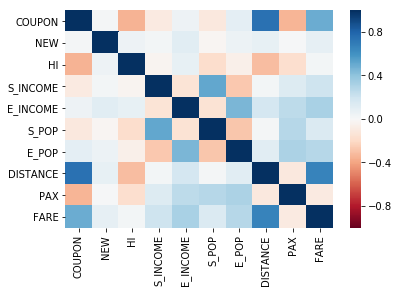

In [3]:
corr = airfare_df.corr()
ax = sns.heatmap(corr, cmap="RdBu", vmin=-1, vmax=1)

corr.style.background_gradient().set_precision(2)

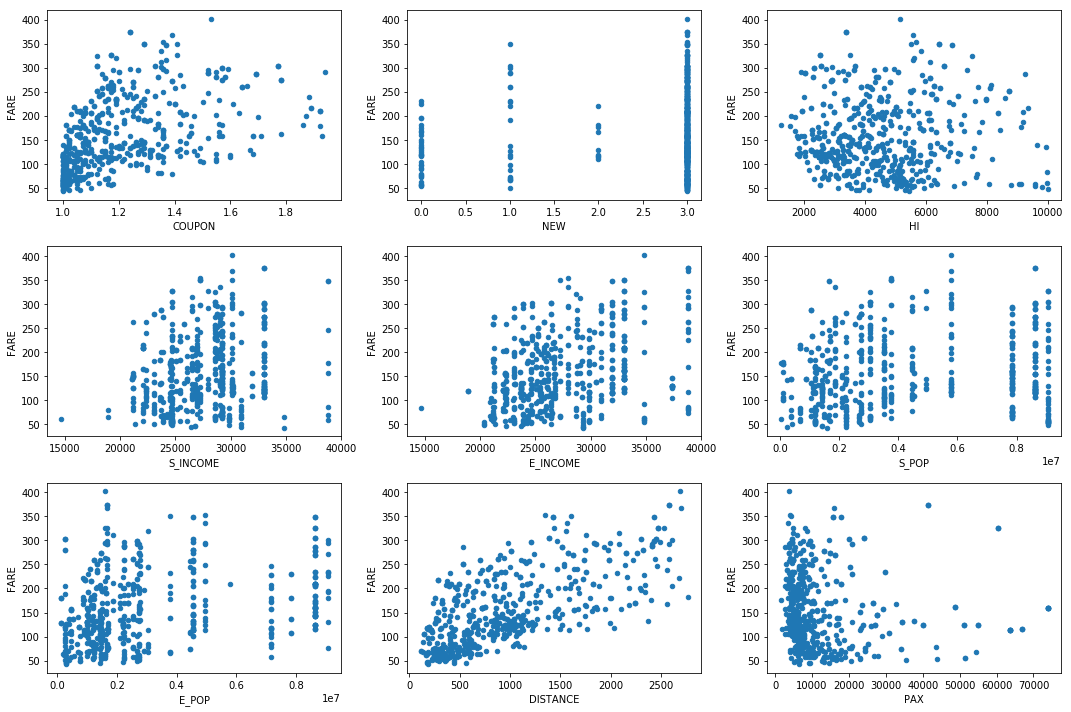

In [4]:
#scatter plot of retail prices versus Screen Size Battery Life RAM Processor HD Size Configuration
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15,10))

airfare_df.plot.scatter(x = 'COUPON', y = 'FARE', ax=axes[0][0])
airfare_df.plot.scatter(x = 'NEW', y = 'FARE', ax=axes[0][1])
airfare_df.plot.scatter(x = 'HI', y = 'FARE', ax=axes[0][2])
airfare_df.plot.scatter(x = 'S_INCOME', y = 'FARE', ax=axes[1][0] )
airfare_df.plot.scatter(x = 'E_INCOME', y = 'FARE', ax=axes[1][1])
airfare_df.plot.scatter(x = 'S_POP', y = 'FARE', ax=axes[1][2] )
airfare_df.plot.scatter(x = 'E_POP', y = 'FARE', ax=axes[2][0] )
airfare_df.plot.scatter(x = 'DISTANCE', y = 'FARE', ax=axes[2][1] )
airfare_df.plot.scatter(x = 'PAX', y = 'FARE', ax=axes[2][2] )

plt.tight_layout()
plt.show()

The best single predictor of FARE is distance.

In [5]:
airfare_df.drop(columns = ['S_CODE', 'S_CITY', 'E_CODE', 'E_CITY'], inplace = True)

In [6]:
airfare_df['VACATION'] = [1 if v == 'Yes' else 0 for v in airfare_df['VACATION']]
airfare_df['SW'] = [1 if v == 'Yes' else 0 for v in airfare_df['SW']]
airfare_df['SLOT'] = [1 if v == 'Controlled' else 0 for v in airfare_df['SLOT']]
airfare_df['GATE'] = [1 if v == 'Controlled' else 0 for v in airfare_df['GATE']]


In [7]:
columns = list(airfare_df.columns)
columns.remove('FARE')
columns.append('FARE')
airfare_df = airfare_df[columns]

In [8]:
train_df = airfare_df.sample(frac=0.6, random_state=12345)
valid_df = airfare_df.drop(train_df.index)

independent_var = list(airfare_df.columns)
independent_var.remove('FARE')

In [9]:
subset = tuple(independent_var)
subset

('COUPON',
 'NEW',
 'VACATION',
 'SW',
 'HI',
 'S_INCOME',
 'E_INCOME',
 'S_POP',
 'E_POP',
 'SLOT',
 'GATE',
 'DISTANCE',
 'PAX')

In [10]:
formula = 'FARE ~ ' + ' + '.join(independent_var)
current_lm = sm.ols(formula=formula, data=airfare_df).fit()
print('Start: AIC={:.0f}'.format(current_lm.aic))
print('FARE ~ ' + ' + '.join(independent_var))
print()
current_var = list(independent_var)
current_aic = current_lm.aic
fmt = '{{0:<{}}} : AIC={{1:.0f}}'.format(max(len(s) for s in current_var))

while len(subset) > 1:
    step = [(current_aic, None)]
    for removeVar in current_var:
        step_var = list(current_var)
        step_var.remove(removeVar)
        step_lm = sm.ols(formula='FARE ~ ' + ' + '.join(step_var), data=airfare_df).fit()
        step.append((step_lm.aic, removeVar))
    step.sort(key=lambda x: x[0])
    for result in step:
        print(fmt.format(result[1] if result[1] is not None else '<None>', result[0]))
    print()
    current_aic, removed_step = step[0]
    if removed_step is None: 
        # stop here, as removing more variables is detrimental to performance
        break
    current_var.remove(removed_step)
    print('Step: AIC={:.0f}'.format(current_aic))
    print('FARE ~ ' + ' + '.join(current_var))
    print()

Start: AIC=6402
FARE ~ COUPON + NEW + VACATION + SW + HI + S_INCOME + E_INCOME + S_POP + E_POP + SLOT + GATE + DISTANCE + PAX

COUPON   : AIC=6401
NEW      : AIC=6402
<None>   : AIC=6402
GATE     : AIC=6402
SLOT     : AIC=6408
S_INCOME : AIC=6408
E_INCOME : AIC=6413
PAX      : AIC=6437
S_POP    : AIC=6438
E_POP    : AIC=6449
HI       : AIC=6475
VACATION : AIC=6490
SW       : AIC=6539
DISTANCE : AIC=6718

Step: AIC=6401
FARE ~ NEW + VACATION + SW + HI + S_INCOME + E_INCOME + S_POP + E_POP + SLOT + GATE + DISTANCE + PAX

NEW      : AIC=6400
<None>   : AIC=6401
GATE     : AIC=6401
S_INCOME : AIC=6406
SLOT     : AIC=6406
E_INCOME : AIC=6412
S_POP    : AIC=6436
PAX      : AIC=6444
E_POP    : AIC=6448
HI       : AIC=6477
VACATION : AIC=6489
SW       : AIC=6539
DISTANCE : AIC=6933

Step: AIC=6400
FARE ~ VACATION + SW + HI + S_INCOME + E_INCOME + S_POP + E_POP + SLOT + GATE + DISTANCE + PAX

<None>   : AIC=6400
GATE     : AIC=6400
S_INCOME : AIC=6405
SLOT     : AIC=6406
E_INCOME : AIC=6411
S_P

In [11]:
airfare_step_lm = sm.ols(formula='FARE ~ ' + ' + '.join(current_var), data=airfare_df).fit()
print(airfare_step_lm.summary())  # Which variables did it drop?

                            OLS Regression Results                            
Dep. Variable:                   FARE   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     218.6
Date:                Tue, 03 Jul 2018   Prob (F-statistic):          6.50e-197
Time:                        18:44:11   Log-Likelihood:                -3189.1
No. Observations:                 638   AIC:                             6400.
Df Residuals:                     627   BIC:                             6449.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.6645     19.687     -1.405      0.1

the binary predictor's sign can explain the positive or negative relationship with fare price, distance has coef = 0.0755 which shows the effect on fare price and also p-value shows significance. 

In [12]:
regressionSummary(airfare_step_lm.predict(valid_df), valid_df.FARE)


Regression statistics

                      Mean Error (ME) : 2.5962
       Root Mean Squared Error (RMSE) : 36.5453
            Mean Absolute Error (MAE) : 29.1348
          Mean Percentage Error (MPE) : -1.8082
Mean Absolute Percentage Error (MAPE) : 21.7217


# COUPON = 1.202, NEW = 3, VACATION = No, SW = No, HI = 4442.141, S_INCOME = 28760, E_INCOME = 27,664, S_POP = 4,557,004, E_POP = 3,195,503, SLOT = Free, GATE = Free, PAX = 12782, DISTANCE = 1976 miles.

In [13]:
newcase = pd.DataFrame([{'COUPON':1.202, 'NEW':3, 'HI':4442.141, 'S_INCOME':28760, 'E_INCOME':27664, 'S_POP':4557004, 
                         'E_POP':3195503, 'DISTANCE':1976, 'PAX':12782, 'VACATION':0, 'SW':0, 
                         'SLOT':0, 'GATE':0}])
airfare_step_lm.predict(newcase)

0    256.491459
dtype: float64

# Variables would actually be available for predicting average fare? 

VACATION, SW, S_INCOME, E_INCOME, S_POP, E_POP, DISTANCE are variables would actually be available for predicting fare.